In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from Lab_Analyses.Utilities.get_dFoF import get_dFoF
%matplotlib notebook
sns.set()
sns.set_style("ticks")

In [2]:
initial_path = r"D:\Suite2P_data\paAIP2"
mouse_ids = ["JW156", "JW157", "JW158", "JW159"]

periods = ["Early", "Middle", "Late"]

In [3]:
import os
F = {}
iscell = {}
for mouse in mouse_ids:
    mouse_f = {}
    mouse_cell = {}
    for period in periods:
        load_path = os.path.join(initial_path, mouse, period, "suite2p", "plane0")
        f_name = os.path.join(load_path, "F.npy")
        cell_name = os.path.join(load_path, "iscell.npy")
        f = np.load(f_name)
        cell = np.load(cell_name)[:, 0].astype(int)
        cell = cell.astype(bool)
        mouse_f[period] = f
        mouse_cell[period] = cell
    F[mouse] = mouse_f
    iscell[mouse] = mouse_cell

In [4]:
fluorescence = {}
for key, value in F.items():
    new_f = {}
    for period, data in value.items():
        cells = iscell[key][period]
        f_cells = data[cells]
        new_f[period] = f_cells.T
    fluorescence[key] = new_f
        

In [14]:
dFoF = {}
processed_dFoF = {}
for key, value in fluorescence.items():
    new_d = {}
    new_pd = {}
    for period, data in value.items():
        d = np.zeros(data.shape)
        pd = np.zeros(data.shape)
        for i in range(data.shape[1]):
            x, y, _ = get_dFoF(data[:, i], 30, 0.5, None, None)
            d[:, i] = x
            pd[:, i] = y
        new_d[period] = d
        new_pd[period] = pd
    dFoF[key] = new_d
    processed_dFoF[key] = new_pd
    

In [15]:
counts = np.zeros((3,4))
counts

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [16]:
for col, (key, value) in enumerate(dFoF.items()):
    for row, (k, v) in enumerate(value.items()):
        counts[row, col] = v.shape[1]

In [17]:
count_dict = {"paAIP2": counts}

In [18]:
from Lab_Analyses.Plotting.plot_multi_line_plot import plot_multi_line_plot

<IPython.core.display.Javascript object>


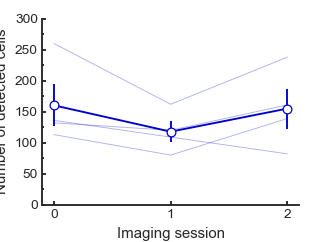

In [19]:

plot_multi_line_plot(
    count_dict,
    x_vals = [0, 1, 2],
    plot_ind=True,
    figsize=(4,3),
    title=None,
    ytitle="Number of detected cells",
    xtitle="Imaging session",
    ylim=(0,300),
    line_color="mediumblue",
    face_color="white",
    m_size=7,
    linewidth=1.5,
    linestyle="-",
    axis_width=1.5,
    minor_ticks="y",
    tick_len=3,
    ax=None,
    legend=False,
    save=False,
    save_path=None
)

In [71]:
plot_data = processed_dFoF["JW156"]["Late"]

<IPython.core.display.Javascript object>


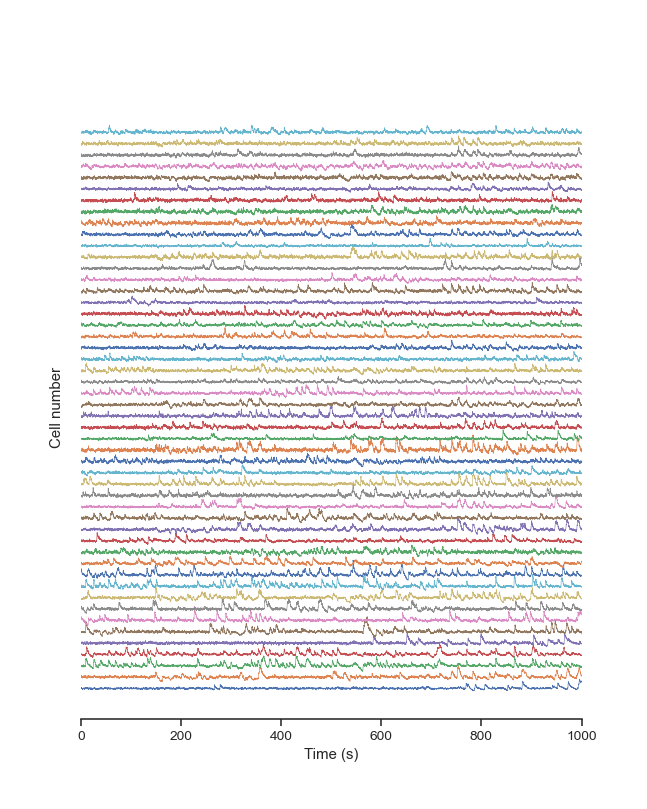

In [76]:
%matplotlib qt
fig, ax = plt.subplots(figsize=(8,10))

for i in range(50):
    x = np.linspace(0, len(plot_data[5000:50000, i]) / 30, len(plot_data[5000:50000, i]))
    ax.plot(x, plot_data[5000:50000, i] + i, linewidth=0.5)

plt.xlabel("Time (s)")
plt.ylabel("Cell number")
plt.xlim(0, 1000)
plt.tick_params(left=False) 
ax.set_yticklabels([])
sns.despine(top=True, right=True, left=True, bottom=False)